In [1]:
#import json
#import pandas as pd
#from datetime import datetime, timedelta
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
#import numpy as np
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

pd.set_option('display.max_rows', None)

def load_data():
    """Load event data from JSON file"""
    # Replace with your actual data loading method
    return pd.DataFrame([
        # Your event data goes here
    ])

def create_corrected_histogram():
    """Create histogram with 6-hour chunk aggregation"""
    df = load_data()
    
    # Flexible datetime handling - use 'start' or 'timestamp'
    if 'start' in df.columns and 'timestamp' in df.columns:
        df['datetime'] = pd.to_datetime(df['start'].fillna(df['timestamp']))
    elif 'start' in df.columns:
        df['datetime'] = pd.to_datetime(df['start'])
    elif 'timestamp' in df.columns:
        df['datetime'] = pd.to_datetime(df['timestamp'])
    else:
        raise ValueError("No time column found - need either 'start' or 'timestamp'")
    
    df = df.dropna(subset=['datetime'])  # Remove any invalid rows
    
    # Calculate 6-hour period number since simulation start
    base_time = df['datetime'].min()
    df['period'] = ((df['datetime'] - base_time).dt.total_seconds() // (6 * 3600)).astype(int)
    
    # Group by patient-practitioner-period
    grouped = df.groupby(['patient_id', 'practitioner_id', 'period'])
    
    aggregates = []
    for (patient_id, practitioner_id, period), group in grouped:
        period_start = base_time + pd.Timedelta(hours=6 * period)
        period_end = period_start + pd.Timedelta(hours=6)
        
        # Event type checks - consider only finished appointments
        has_appt = ((group['type'] == 'Appointment') & 
                   (group['status'] == 'finished')).any()
        has_obs = (group['type'] == 'Observation').any()
        has_enc = (group['type'] == 'Encounter').any()
        
        # Handle AuditEvents with flexible data access
        has_btg = False
        has_care = False
        if 'data' in group.columns:
            audit_events = group[group['type'] == 'AuditEvent']
            if not audit_events.empty:
                has_btg = audit_events['data'].apply(
                    lambda x: x.get('event_type') == 'EMERGENCY').any()
                has_care = audit_events['data'].apply(
                    lambda x: x.get('event_type') == 'CARE').any()
        
        aggregates.append({
            'patient_id': patient_id,
            'practitioner_id': practitioner_id,
            'period': period,
            'period_start': period_start,
            'period_end': period_end,
            'has_appointment': has_appt,
            'has_observation': has_obs,
            'has_encounter': has_enc,
            'has_btg_access': has_btg,
            'has_care_access': has_care
        })
    
    aggregates_df = pd.DataFrame(aggregates)
    
    # Add table IDs and labels
    aggregates_df['table_id'] = aggregates_df.apply(calculate_table_id, axis=1)
    aggregates_df['label'] = aggregates_df.apply(determine_label, axis=1)
    
    # Visualization
    plot_distribution(aggregates_df)
    return aggregates_df

def calculate_table_id(row):
    """Calculate table ID (0-16) with CARE access handling"""
    a = row['has_appointment']
    o = row['has_observation']
    e = row['has_encounter']
    b = row['has_btg_access']
    c = row['has_care_access']
    
    # Decision tree for table IDs
    if not a and not o and not e and not b and not c: return 0
    if not a and not o and not e and not b and c: return 1
    if not a and not o and not e and b: return 2
    if not a and not o and e and not b: return 3
    if not a and not o and e and b: return 4
    if not a and o and not e and not b: return 5
    if not a and o and not e and b: return 6
    if not a and o and e and not b: return 7
    if not a and o and e and b: return 8
    if a and not o and not e and not b: return 9
    if a and not o and not e and b: return 10
    if a and not o and e and not b: return 11
    if a and not o and e and b: return 12
    if a and o and not e and not b: return 13
    if a and o and not e and b: return 14
    if a and o and e and not b: return 15
    if a and o and e and b: return 16
    raise ValueError(f"Unhandled combination: a={a}, o={o}, e={e}, b={b}, c={c}")

def determine_label(row):
    """Classify as Normal/Anomaly with CARE access handling"""
    table_id = row['table_id']
    # Anomaly cases (based on business rules)
    if table_id in [1, 3, 5, 7, 10]:
        return 'Anomaly'
    return 'Normal'

def plot_distribution(df):
    """Plot the distribution with fixed indexing"""
    # Get counts and ensure full 0-16 range
    count_data = df.groupby(['table_id', 'label']).size()
    id_counts = count_data.unstack(fill_value=0).reindex(range(0,17), fill_value=0)
    
    # Ensure both label columns exist
    for col in ['Normal', 'Anomaly']:
        if col not in id_counts:
            id_counts[col] = 0
            
    plt.figure(figsize=(14, 7))
    ax = plt.gca()
    colors = {'Normal': '#4CAF50', 'Anomaly': '#F44336'}
    
    # Plot stacked bars
    x = id_counts.index
    bottom = np.zeros(len(x))
    for label, color in colors.items():
        counts = id_counts.get(label, np.zeros(len(x)))
        ax.bar(x, counts, bottom=bottom, 
               color=color, label=label, edgecolor='white', width=0.8)
        bottom += counts
    
    # Customize plot
    plt.title('Classification Distribution', fontsize=14)
    plt.xlabel('Table ID (0-16)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(range(0, 17))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add legend and value labels
    ax.legend(title='Classification')
    for table_id in x:
        total = id_counts.loc[table_id].sum()
        if total > 0:  # Only label if count > 0
            plt.text(table_id, total + 0.1, str(total), 
                     ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('./classification_distribution.png', dpi=300)
    plt.show()

# Run the analysis
print("Processing data...")
result_df = create_corrected_histogram()

# Print summary statistics
print("\nClassification Summary:")
print(result_df['label'].value_counts())
print("\nDetailed Table ID Distribution:")
print(result_df['table_id'].value_counts().sort_index())

# Save results
result_df.to_csv('./labeled_events_with_care.csv', index=False)
print("\nResults saved to labeled_events_with_care.csv")

Processing data...


ValueError: No time column found - need either 'start' or 'timestamp'

In [ ]:
main()

In [ ]:
# 1. Load and preprocess data (same as before)
def load_and_preprocess_data():
    with open('./events.json') as f:
        events = json.load(f)
    df = pd.DataFrame(events)
    df['date'] = pd.to_datetime(df['start'].fillna(df['timestamp'])).dt.date
    return df

# 2. Create daily aggregates and label data (same as before)
def create_daily_aggregates(df):
    grouped = df.groupby(['patient_id', 'practitioner_id', 'date'])
    aggregates = []
    for (patient_id, practitioner_id, date), group in grouped:
        aggregates.append({
            'patient_id': patient_id,
            'practitioner_id': practitioner_id,
            'date': date,
            'has_appointment': (group['type'] == 'Appointment').any(),
            'has_observation': (group['type'] == 'Observation').any(),
            'has_encounter': (group['type'] == 'Encounter').any(),
            'has_btg': ((group['type'] == 'AuditEvent') & 
                       (group['data'].apply(lambda x: x.get('event_type') == 'EMERGENCY'))).any()
        })
    return pd.DataFrame(aggregates)

def label_data(aggregates):
    labels = []
    for _, row in aggregates.iterrows():
        a, o, e, b = row['has_appointment'], row['has_observation'], row['has_encounter'], row['has_btg']
        # Classification rules from the table
        label = 'Normal' if any([
            (not a and not o and not e and b),     # ID 2
            (not a and not o and e and b),          # ID 4
            (not a and o and not e and b),          # ID 6
            (not a and o and e and b),              # ID 8
            (a and not o and not e and not b),      # ID 9
            (a and not o and e and not b),          # ID 11
            (a and not o and e and b),              # ID 12
            (a and o and not e and not b),          # ID 13
            (a and o and not e and b),              # ID 14
            (a and o and e and not b),              # ID 15
            (a and o and e and b)                   # ID 16
        ]) else 'Anomaly'
        labels.append(label)
    aggregates['label'] = labels
    return aggregates

# 3. Prepare models for evaluation
def get_models():
    return {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Naive Bayes': GaussianNB(),
        'k-NN (k=3)': KNeighborsClassifier(n_neighbors=3)
    }

# 4. Evaluate models with learning curves
def evaluate_models(X, y):
    models = get_models()
    results = {}
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Common CV strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        
        # Calculate learning curve
        train_sizes, train_scores, test_scores = learning_curve(
            estimator=model,
            X=X,
            y=y_encoded,
            train_sizes=np.linspace(0.1, 1.0, 10),
            cv=cv,
            scoring='accuracy',
            n_jobs=-1
        )
        
        # Store results
        results[name] = {
            'train_sizes': train_sizes,
            'train_scores': train_scores,
            'test_scores': test_scores,
            'mean_train': np.mean(train_scores, axis=1),
            'mean_test': np.mean(test_scores, axis=1),
            'std_train': np.std(train_scores, axis=1),
            'std_test': np.std(test_scores, axis=1)
        }
        
        # Print final performance
        final_acc = results[name]['mean_test'][-1]
        print(f"Final accuracy: {final_acc:.3f}")
    
    return results

# 5. Plot learning curves
def plot_learning_curves(results):
    plt.figure(figsize=(12, 8))
    
    for name, data in results.items():
        plt.plot(data['train_sizes'], data['mean_test'], 
                label=f'{name} (Test)', linestyle='-', marker='o')
        plt.fill_between(data['train_sizes'], 
                        data['mean_test'] - data['std_test'],
                        data['mean_test'] + data['std_test'],
                        alpha=0.1)
        
        plt.plot(data['train_sizes'], data['mean_train'], 
                label=f'{name} (Train)', linestyle='--', marker='o')
        plt.fill_between(data['train_sizes'], 
                        data['mean_train'] - data['std_train'],
                        data['mean_train'] + data['std_train'],
                        alpha=0.1)
    
    plt.title('Learning Curves for Different Models')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig('./learning_curves.png')
    plt.show()

# 6. Main execution
def main():
    # Load and preprocess data
    df = load_and_preprocess_data()
    
    # Create daily aggregates
    aggregates = create_daily_aggregates(df)
    
    # Label the data
    labeled_data = label_data(aggregates)
    
    # Prepare features and target
    X = labeled_data[['has_appointment', 'has_observation', 'has_encounter', 'has_btg']].astype(int)
    print(X)
    return
    y = labeled_data['label']
    
    # Evaluate models with learning curves
    results = evaluate_models(X, y)
    
    # Plot learning curves
    plot_learning_curves(results)
    
    # Save results for further analysis
    with open('./model_evaluation_results.json', 'w') as f:
        json.dump({
            'model_names': list(results.keys()),
            'train_sizes': results[list(results.keys())[0]]['train_sizes'].tolist(),
            'accuracies': {name: res['mean_test'].tolist() for name, res in results.items()}
        }, f)

In [ ]:
main()

In [ ]:
# import json
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.patches import Patch

# pd.set_option('display.max_rows', None)

# def load_data():
#     """Load event data from JSON file"""
#     with open('./events.json') as f:
#         events = json.load(f)
#     return pd.DataFrame(events)

# def create_corrected_histogram():
#     """Create histogram with exact 24-hour chunk aggregation"""
#     df = load_data()
    
#     # Convert all timestamps to datetime and calculate 24-hour periods
#     df['datetime'] = pd.to_datetime(df['start'].fillna(df['timestamp']))
    
#     # Calculate 24-hour period number (0-based) since simulation start
#     df['period'] = (df['datetime'] - df['datetime'].min()).dt.total_seconds() // (6 * 3600)
    
#     # Group by patient-practitioner 24 hour period
#     grouped = df.groupby(['patient_id', 'practitioner_id', 'period'])
    
#     aggregates = []
#     for (patient_id, practitioner_id, period), group in grouped:
#         # Get the actual datetime range for this period
#         period_start = df['datetime'].min() + pd.Timedelta(days=period)
#         period_end = period_start + pd.Timedelta(hours=6)
        
#         has_appt = (group['type'] == 'Appointment').any()
#         has_obs = (group['type'] == 'Observation').any()
#         has_enc = (group['type'] == 'Encounter').any()
#         has_btg = ((group['type'] == 'AuditEvent') & 
#                   (group['data'].apply(lambda x: x.get('event_type') == 'EMERGENCY'))).any()
#         has_care = ((group['type'] == 'AuditEvent') & 
#                    (group['data'].apply(lambda x: x.get('event_type') == 'CARE'))).any()
        
#         aggregates.append({
#             'patient_id': patient_id,
#             'practitioner_id': practitioner_id,
#             'period': int(period),
#             'period_start': period_start,
#             'period_end': period_end,
#             'has_appointment': has_appt,
#             'has_observation': has_obs,
#             'has_encounter': has_enc,
#             # Access Events:
#             'has_btg_access': has_btg,
#             'has_care_access': has_care
#         })
    
#     aggregates_df = pd.DataFrame(aggregates)
    
#     # Add table IDs and labels
#     aggregates_df['table_id'] = aggregates_df.apply(calculate_table_id, axis=1)
#     aggregates_df['label'] = aggregates_df.apply(determine_label, axis=1)
    
#     # Visualization
#     plot_distribution(aggregates_df)
#     return aggregates_df

# def calculate_table_id(row):
#     """Calculate table ID (1-16) with CARE access handling"""
#     a = row['has_appointment']
#     o = row['has_observation']
#     e = row['has_encounter']
#     b = row['has_btg_access']
#     c = row['has_care_access']
    
#     if not a and not o and not e and not b and not c: return 0 # No data within the 24 hour period
#     if not a and not o and not e and not b and c: return 1
#     if not a and not o and not e and b: return 2
#     if not a and not o and e and not b: return 3
#     if not a and not o and e and b: return 4
#     if not a and o and not e and not b: return 5
#     if not a and o and not e and b: return 6
#     if not a and o and e and not b: return 7
#     if not a and o and e and b: return 8
#     if a and not o and not e and not b: return 9
#     if a and not o and not e and b: return 10
#     if a and not o and e and not b: return 11
#     if a and not o and e and b: return 12
#     if a and o and not e and not b: return 13
#     if a and o and not e and b: return 14
#     if a and o and e and not b: return 15
#     if a and o and e and b: return 16
#     raise ValueError

# def determine_label(row):
#     """Classify as Normal/Anomaly with proper CARE access handling"""
#     table_id = row['table_id']
    
#     # Anomaly cases:
#     if table_id in [1, 3, 5, 7, 10]:
#         return 'Anomaly'
#     # All others are Normal
#     return 'Normal'

# def plot_distribution(df):
#     """Plot the distribution"""
#     id_counts = df.groupby(['table_id', 'label']).size().unstack(fill_value=0)
    
#     plt.figure(figsize=(14, 7))
#     ax = plt.gca()
#     colors = {'Normal': '#4CAF50', 'Anomaly': '#F44336'}
    
#     # Plot stacked bars
#     bottom = np.zeros(len(id_counts))
#     for label, color in colors.items():
#         if label in id_counts:
#             counts = id_counts[label]
#             ax.bar(id_counts.index, counts, bottom=bottom, 
#                    color=color, label=label, edgecolor='white', width=0.8)
#             bottom += counts
    
#     # Customize plot
#     plt.title('Classification Distribution', fontsize=14)
#     plt.xlabel('Table ID (1-16)', fontsize=12)
#     plt.ylabel('Count', fontsize=12)
#     plt.xticks(range(0, 17))
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
        
#     # Add legend and value labels
#     ax.legend(title='Classification')
#     for case_id in id_counts.index:
#         total = id_counts.loc[case_id].sum()
#         plt.text(case_id, total + 0.5, str(total), ha='center', va='bottom')
    
#     plt.tight_layout()
#     plt.savefig('./classification_distribution.png', dpi=300)
#     plt.show()

# # Run the analysis
# print("Processing data...")
# result_df = create_corrected_histogram()
# result_df
# # Print summary statistics
# # print("\nClassification Summary:")
# # print(result_df['label'].value_counts())
# # print("\nDetailed Table ID Distribution:")
# # print(result_df['table_id'].value_counts().sort_index())

# # Save results
# # result_df.to_csv('./labeled_events_with_care.csv', index=False)
# # print("\nResults saved to labeled_events_with_care.csv")

Processing data...


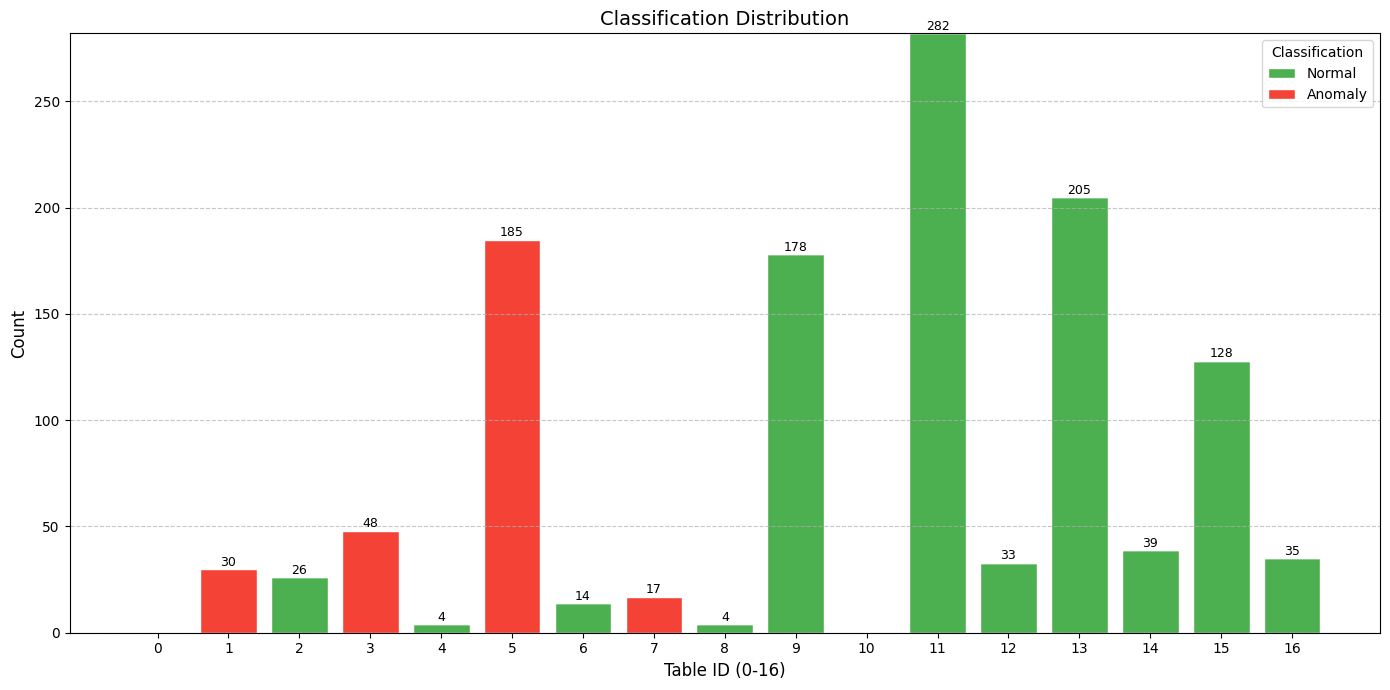

In [10]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

pd.set_option('display.max_rows', None)

def load_data():
    """Load event data from JSON file"""
    with open('./events.json') as f:
        events = json.load(f)
    return pd.DataFrame(events)

def create_corrected_histogram():
    """Create histogram with 6-hour chunk aggregation"""
    df = load_data()
    
    # Flexible datetime handling - use 'start' or 'timestamp'
    if 'start' in df.columns and 'timestamp' in df.columns:
        df['datetime'] = pd.to_datetime(df['start'].fillna(df['timestamp']))
    elif 'start' in df.columns:
        df['datetime'] = pd.to_datetime(df['start'])
    elif 'timestamp' in df.columns:
        df['datetime'] = pd.to_datetime(df['timestamp'])
    else:
        raise ValueError("No time column found - need either 'start' or 'timestamp'")
    
    #df = df.dropna(subset=['datetime'])  # Remove any invalid rows
    
    # Calculate 6-hour period number since simulation start
    hours = 12
    base_time = df['datetime'].min()
    df['period'] = ((df['datetime'] - base_time).dt.total_seconds() // (hours * 3600)).astype(int)
    
    # Group by patient-practitioner-period
    grouped = df.groupby(['patient_id', 'practitioner_id', 'period'])

    
    aggregates = []
    for (patient_id, practitioner_id, period), group in grouped:
        period_start = base_time + pd.Timedelta(hours=hours * period)
        period_end = period_start + pd.Timedelta(hours=hours)
        
        # Event type checks - consider only finished appointments
        #has_appt = ((group['type'] == 'Appointment') & 
        #           (group['status'] == 'finished')).any()
        has_appt = (group['type'] == 'Appointment').any()
        has_obs = (group['type'] == 'Observation').any()
        has_enc = (group['type'] == 'Encounter').any()
        
        # Handle AuditEvents with flexible data access
        has_btg = False
        has_care = False
        if 'data' in group.columns:
            audit_events = group[group['type'] == 'AuditEvent']
            if not audit_events.empty:
                has_btg = audit_events['data'].apply(
                    lambda x: x.get('purpose') == 'BTG').any()
                has_care = audit_events['data'].apply(
                    lambda x: x.get('purpose') == 'CAREMGT').any()
        
        aggregates.append({
            'patient_id': patient_id,
            'practitioner_id': practitioner_id,
            'period': period,
            'period_start': period_start,
            'period_end': period_end,
            'has_appointment': has_appt,
            'has_observation': has_obs,
            'has_encounter': has_enc,
            'has_btg_access': has_btg,
            'has_care_access': has_care
        })
    
    aggregates_df = pd.DataFrame(aggregates)
    
    # Add table IDs and labels
    aggregates_df['table_id'] = aggregates_df.apply(calculate_table_id, axis=1)
    aggregates_df['label'] = aggregates_df.apply(determine_label, axis=1)
    return aggregates_df

def calculate_table_id(row):
    """Calculate table ID (0-16) with CARE access handling"""
    a = row['has_appointment']
    o = row['has_observation']
    e = row['has_encounter']
    b = row['has_btg_access']
    c = row['has_care_access']

    # Decision tree for table IDs
    if not a and not o and not e and not b and not c: return 0
    if not a and not o and not e and not b and c: return 1
    if not a and not o and not e and b: return 2
    if not a and not o and e and not b: return 3
    if not a and not o and e and b: return 4
    if not a and o and not e and not b: return 5
    if not a and o and not e and b: return 6
    if not a and o and e and not b: return 7
    if not a and o and e and b: return 8
    if a and not o and not e and not b: return 9
    if a and not o and not e and b: return 10
    if a and not o and e and not b: return 11
    if a and not o and e and b: return 12
    if a and o and not e and not b: return 13
    if a and o and not e and b: return 14
    if a and o and e and not b: return 15
    if a and o and e and b: return 16
    raise ValueError(f"Unhandled combination: a={a}, o={o}, e={e}, b={b}, c={c}")

def determine_label(row):
    """Classify as Normal/Anomaly with CARE access handling"""
    table_id = row['table_id']
    # Anomaly cases (based on business rules)
    if table_id in [1, 3, 5, 7, 10]:
        return 'Anomaly'
    return 'Normal'

def plot_distribution(df):
    """Plot the distribution with fixed indexing"""
    # Get counts and ensure full 0-16 range
    count_data = df.groupby(['table_id', 'label']).size()
    id_counts = count_data.unstack(fill_value=0).reindex(range(0,17), fill_value=0)
    
    # Ensure both label columns exist
    for col in ['Normal', 'Anomaly']:
        if col not in id_counts:
            id_counts[col] = 0
            
    plt.figure(figsize=(14, 7))
    ax = plt.gca()
    colors = {'Normal': '#4CAF50', 'Anomaly': '#F44336'}
    
    # Plot stacked bars
    x = id_counts.index
    bottom = np.zeros(len(x))
    for label, color in colors.items():
        counts = id_counts.get(label, np.zeros(len(x)))
        ax.bar(x, counts, bottom=bottom, 
               color=color, label=label, edgecolor='white', width=0.8)
        bottom += counts
    
    # Customize plot
    plt.title('Classification Distribution', fontsize=14)
    plt.xlabel('Table ID (0-16)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(range(0, 17))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add legend and value labels
    ax.legend(title='Classification')
    for table_id in x:
        total = id_counts.loc[table_id].sum()
        if total > 0:  # Only label if count > 0
            plt.text(table_id, total + 0.1, str(total), 
                     ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('./classification_distribution.png', dpi=300)
    plt.show()

# Run the analysis
print("Processing data...")
result_df = create_corrected_histogram()

#print(result_df.head(100))
# Visualization
#plot_distribution(result_df[result_df["has_care_access"] == True])
plot_distribution(result_df)

#result_df[result_df["has_btg_access"] == True]

# Print summary statistics
#print("\nClassification Summary:")
#print(result_df['label'].value_counts())
#print("\nDetailed Table ID Distribution:")
#print(result_df['table_id'].value_counts().sort_index())

# Save results
#result_df.to_csv('./labeled_events_with_care.csv', index=False)
#print("\nResults saved to labeled_events_with_care.csv")